In [7]:
import random
import operator

city_num = []
random.shuffle

<bound method Random.shuffle of <random.Random object at 0x0000027A5027C580>>

In [8]:
def select(chromosome_list,fitness_ratio_add):
    rand_list = [random.uniform(0, 1) for _ in chromosome_list]     # 生成和种群规模相等的随机值列表，用于轮盘赌选择个体
    rand_list.sort()
    fit_index =0
    new_index = 0
    new_pop = chromosome_list.copy()
    while new_index < len(chromosome_list):
        if rand_list[new_index] < fitness_ratio_add[fit_index]:
            new_pop[new_index] = chromosome_list[fit_index]
            new_index = new_index +1
        else:
            fit_index = fit_index+1
    return new_pop

In [9]:
def select_sorted_population(fitness, population, length):
    global population_size
    sort_dict = {}
    for i in range(len(population)):
        sort_dict[(fitness[i], 1 / fitness[i])] = i

    sorted_key = sorted(sort_dict.keys(), key=operator.itemgetter(0), reverse=True)

    sorted_index = [sort_dict[i] for i in sorted_key]
    sorted_population = [population[i] for i in sorted_index]

    return sorted_population[:length]


In [10]:
## 交换基因操作
def exchange(chromosome_list,pc):
    for i in range(0, len(chromosome_list) - 1, 2):
            if random.uniform(0, 1) < pc:
                index_1 = random.randint(0, len(chromosome_list[0])-1)
                index_2 = random.randint(index_1, len(chromosome_list[0])-1)
                temp_gene_1 = chromosome_list[i+1][index_1:index_2]
                # 随机生成交叉点
                newGene_1 = []
                p1len = 0
                for g in chromosome_list[i]:

                    if p1len == index_1:
                            newGene_1.extend(temp_gene_1)                               #插入基因片段
                            p1len += 1
                    if g not in temp_gene_1:
                            newGene_1.append(g)
                            p1len += 1

                index_1 = random.randint(0, len(chromosome_list[0])-1)
                index_2 = random.randint(index_1, len(chromosome_list[0])-1)
                temp_gene_2 = chromosome_list[i][index_1:index_2]
                # 随机生成交叉点
                newGene_2 = []
                p1len = 0
                for g in chromosome_list[i+1]:

                    if p1len == index_1:
                            newGene_2.extend(temp_gene_2)                               #插入基因片段
                            p1len += 1
                    if g not in temp_gene_2:
                            newGene_2.append(g)
                            p1len += 1
                chromosome_list[i] = newGene_1
                chromosome_list[i+1] = newGene_2
    return chromosome_list

In [11]:
## 变异操作 某个城市变异
def mutation(chromosome_list,mc):
    for i in range(len(chromosome_list)):
        if random.uniform(0,1) < mc:
            m_point = random.randint(0,len(chromosome_list[0])-1)
            rand_num = random.randint(0,26)
            old_num = chromosome_list[i][m_point]
            chromosome_list[i][m_point] = rand_num
            chromosome_list[i][np.argwhere(np.asarray(chromosome_list[i]) == rand_num)[0][0]] = old_num
            
    return chromosome_list

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.scatterplot(data_tsp.x,data_tsp.y)

NameError: name 'data_tsp' is not defined

优化样本选择过程

首先选择最优四分之一样本
其次通过轮盘赌选择当前较优的样本进行crossover

In [13]:
# 轮赌盘选择算子
def selection(fitness, num):
    def select_one(fitness, fitness_sum):
        size = len(fitness)
        i = random.randint(0, size - 1)
        while True:
            if random.random() < fitness[i] / fitness_sum:
                return i
            else:
                i = (i + 1) % size

    res = set()
    fitness_sum = sum(fitness)
    while len(res) < num:
        t = select_one(fitness, fitness_sum)
        res.add(t)
    return res

In [14]:

# 排序，并且返回length长的population
def select_sorted_population(fitness, population, length):
    sort_dict = {}
    for i in range(len(population)):
        sort_dict[(fitness[i], 1 / fitness[i])] = i

    sorted_key = sorted(sort_dict.keys(), key=operator.itemgetter(0), reverse=True)

    sorted_index = [sort_dict[i] for i in sorted_key]
    sorted_population = [population[i] for i in sorted_index]

    return sorted_population[:length]

In [15]:
## 轮盘赌选出两个比较好的然后，在对他们进行交叉复制，然后再进行变异
# 轮赌盘选择算子
def selection(fitness, num):
    def select_one(fitness, fitness_sum):
        size = len(fitness)
        i = random.randint(0, size - 1)
        while True:
            if random.random() < fitness[i] / fitness_sum:
                return i
            else:
                i = (i + 1) % size

    res = set()
    fitness_sum = sum(fitness)
    while len(res) < num:
        t = select_one(fitness, fitness_sum)
        res.add(t)
    return res

def crossover(p1,p2):
    a = random.randint(0,len(p1)-1)
    p1_part,p2_part = p1[a:],p2[a:]
    p1_part_new = []
    p2_part_new = []
    for i in p1:
        if i not in p2_part:
            p1_part_new.append(i)
    p1_part_new.appned(p2_part)
    for i in p2:
        if i not in p1_part:
            p2_part_new.append(i)
    p2_part_new.appned(p1_part)



    

In [16]:
# 杂交算子
def crossover(parent1, parent2):

    a = random.randint(1, len(parent1) - 1)
    child1, child2 = parent1[:a], parent2[:a]

    for i in range(len(parent1)):
        if parent2[i] not in child1:
            child1.append(parent2[i])

        if parent1[i] not in child2:
            child2.append(parent1[i])

    return child1, child2


def get_two(length):
    b=a = random.randint(0,length-1)
    while a==b:
        b = random.randint(0,length-1)
    if a>b:
        return b,a
    else: return a,b

def mutaion_exchange(s):
    # 自己手写的2变换
    a, b = get_two(len(s))
    for i in range(a, (a + b) // 2 + 1):
        s[i], s[b + a - i] = s[b + a - i], s[i]

    return s

# 滑动变异
def slide_mutation(s):
    a, b = get_two(len(s))
    t = s[a]
    for i in range(a + 1, b + 1):
        s[i - 1] = s[i]
    s[b] = t
    return s

def get_fitness_one(p1,dist_matrix):
    fitness_list = []
    for i in range(dist_matrix.shape[0]-1):
        if i != dist_matrix.shape[0]-1:
            fitness_list.append(1/dist_matrix[p1[i],p1[i+1]])
        else: fitness_list.append(1/dist_matrix[p1[city_num-1],p1[0]])
    return sum(fitness_list)
# SMB
def select_best_mutaion(s, dist_matrix):
    s_res = [mutaion_exchange(s[:]), slide_mutation(s[:])]
    res = [get_fitness_one(s_res[0], dist_matrix), get_fitness_one(s_res[1], dist_matrix)]

    min_index = res.index(max(res))

    return s_res[min_index]    

In [17]:
## 随机生成20个初始随机路线
import itertools
import pandas as pd
city_num = 70
p_mutation = 0.02
data_y = [random.uniform(1,10) for _ in range(city_num)]
data_x = [random.uniform(1,10) for _ in range(city_num)]
row_id = [i for i in range(city_num)]
data_tsp = pd.DataFrame(columns =['x','y','id'])
data_tsp['x']= data_x
data_tsp['y']= data_y
data_tsp['id']= row_id
chromosome_list = []
sample_1 = [i for i in range(city_num)]


C:\Users\Louie.CNL-HYDN6G3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: unhashable type: 'numpy.ndarray'

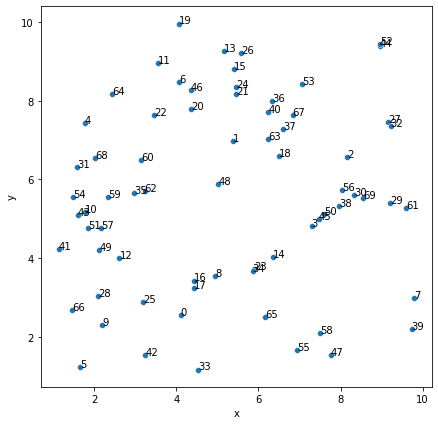

In [18]:

population_size = 50
for i in range(population_size):
    random.shuffle(sample_1)
    chromosome_list.append(sample_1[:])


from matplotlib import pyplot as plt
import seaborn as sns
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(data_tsp.x,data_tsp.y,ax =axes)
for i in range(len(data_tsp.x)):
    x_t = data_tsp.x[i]
    y_t = data_tsp.y[i]
    axes.annotate(text = data_tsp.index[i], xy=(x_t, y_t), xytext=(x_t, y_t))

## 计算两两之间距离
import numpy as np
dist_matrix =  np.zeros([city_num,city_num])
for i in range(city_num):
    for j in range(city_num):
        a = data_tsp[data_tsp['id']==i][['x','y']].loc[i]-data_tsp[data_tsp['id']==j][['x','y']].loc[j]
        dist_matrix[i,j] = a.x**2 + a.y**2


## 循环优化
fitness_ratio_list = get_fitness(chromosome_list,dist_matrix)
fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
fitness_ratio_add = fitness_ratio_add/sum(fitness_ratio_list)
import itertools
best_result = []
best_fitness = []
generation = 5000
picture = [0.001,0.005,0.01,0.02,0.05,0.08,0.1,0.2,0.3,0.5,0.8,1]
picture_new = [i * generation for i in picture]
population_cur = chromosome_list
d = 0
fig,axes = plt.subplots(3,4,figsize=(40,20)) 
for t in range(0,generation,1):
    ## 选出比较好的前1/4样本
    population_next = select_sorted_population(fitness_ratio_list,population_cur,len(chromosome_list)//4)
    for i in range(population_size):
        a,b = selection(fitness_ratio_list,2)
        child1,child2 = crossover(population_cur[a],population_cur[b])
            # 变异
        if random.random() < p_mutation:
                child1 = select_best_mutaion(child1,dist_matrix)
        if random.random() < p_mutation:
                child2 = select_best_mutaion(child2,dist_matrix)      
        population_next.append(child1)
        population_next.append(child2)

        # 选出下一代的种群
    fitness_ratio_list = get_fitness(population_next,dist_matrix)
    population_next = select_sorted_population(fitness_ratio_list, population_next, population_size)
    population_cur = population_next
    fitness_ratio_list = get_fitness(population_cur,dist_matrix)
    fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
    fitness_ratio_add = fitness_ratio_add/sum(fitness_ratio_list)
    best_result.append(population_cur[int(np.argwhere(fitness_ratio_list == max(fitness_ratio_list))[0])])
    best_fitness.append(max(fitness_ratio_list))
    
    if int(t+1) == int(picture_new[d]):
            x1 = []
            y1 =[]
            x2 =[]
            y2 = []
            if (d+1)%4 ==0:
                e,g = (d+1)//4-1,3
            else: e,g=(d+1)//4,d%4
            for i in range(len(data_tsp)):
                x1.append(data_tsp.x[i])
                y1.append(data_tsp.y[i])
            for i in range(len(best_result[0])):
                x2.append(data_tsp.x[best_result[best_fitness.index(max(best_fitness))][i]])
                y2.append(data_tsp.y[best_result[best_fitness.index(max(best_fitness))][i]])
            axes[e,g].plot(x2,y2,color='blue',marker='o' ); #画点
            for i in range(len(x2)):
                axes[e,g].text(x2[i],y2[i],i+1) 
            d =d+ 1
            print(e,g)
    
    
# x = [i for i in range(generation)]
# fig1 = plt.figure('figure', figsize=(13, 5)).add_subplot(121)
# fig1.plot(x, best_fitness)
# plt.show()
# print("self.best_dist",end=":")

# print("self.best_individual",end=":")

# x1=[]
# y1=[]
# x2=[]
# y2=[]
# for i in range(len(data_tsp)):
#     x1.append(data_tsp.x[i])
#     y1.append(data_tsp.y[i])
# for i in range(len(best_result[0])):
#     x2.append(data_tsp.x[best_result[best_fitness.index(max(best_fitness))][i]])
#     y2.append(data_tsp.y[best_result[best_fitness.index(max(best_fitness))][i]])
# plt.title("citys_position")
# plt.scatter(x1,y1,color='blue',marker='o' ); #画点
# plt.figure();
# plt.title("best_route")
# plt.plot(x2,y2,color='blue',marker='o' ); #画点
# for i in range(len(x2)):
#     plt.text(x2[i],y2[i],i+1)
# plt.figure();
# plt.title("best_dist_change")
# ## plt.plot(self.best_dist_list,color='r')
# plt.show()

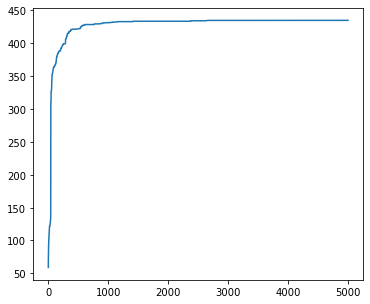

self.best_dist:self.best_individual:x1:[7.93194442090295, 6.0739637371081, 1.4025891202406982, 6.891718487284663, 2.785774986816569, 7.21995021459626, 9.324494927936673, 8.98414200126045, 2.304408349988244, 6.604156206850852, 2.7192002617263773, 5.397669028291162, 3.8338509498414766, 4.218022834237772, 1.4959050209080786, 1.5752914185759106, 8.166305740596261, 5.381744242842901, 2.3210497197671103, 5.2838680067006, 6.452368844786681, 2.1072574299257973, 1.5735698462195502, 9.23800906721146, 6.755134199973672, 8.489477439185404, 2.8835622421169247, 3.327894275728514, 4.068720368955864, 2.7499605251442945, 3.230163018219896, 9.079847657371499, 9.219307013399192, 4.325427783731323, 5.053744818866777, 7.479876028749154, 5.6561053382281035, 4.768753718796603, 3.2614190405821546, 4.872844910294348, 6.012935460274886, 4.980714487028209, 6.339056496463559, 1.2717665410707368, 4.267702699443596, 6.601573951241941, 3.0423459111014948, 8.675345256514106, 2.137770015099782, 5.524464085248235, 2.32

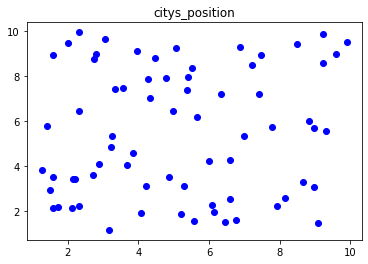

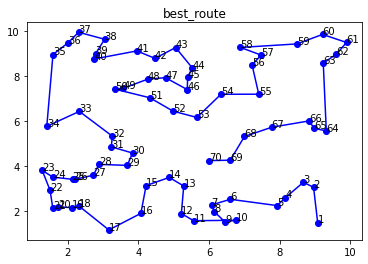

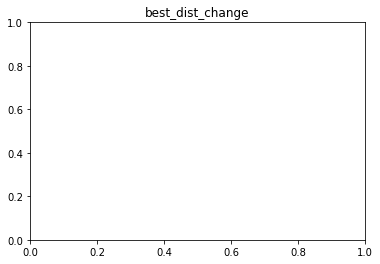

In [17]:
x = [i for i in range(generation)]
fig1 = plt.figure('figure', figsize=(13, 5)).add_subplot(121)
fig1.plot(x, best_fitness)
plt.show()
print("self.best_dist",end=":")

print("self.best_individual",end=":")

x1=[]
y1=[]
x2=[]
y2=[]
for i in range(len(data_tsp)):
    x1.append(data_tsp.x[i])
    y1.append(data_tsp.y[i])
for i in range(len(best_result[0])):
    x2.append(data_tsp.x[best_result[best_fitness.index(max(best_fitness))][i]])
    y2.append(data_tsp.y[best_result[best_fitness.index(max(best_fitness))][i]])
print("x1:",end="")
print(x1)
print("y1:",end="")
print(y1)
print("x2:",end="")
print(x2)
print("y2:",end="")
print(y2)
plt.title("citys_position")
plt.scatter(x1,y1,color='blue',marker='o' ); #画点
plt.figure();
plt.title("best_route")
plt.plot(x2,y2,color='blue',marker='o' ); #画点
for i in range(len(x2)):
    plt.text(x2[i],y2[i],i+1)
plt.figure();
plt.title("best_dist_change")
## plt.plot(self.best_dist_list,color='r')
plt.show()

## ***构建报价选择算法并设置通用参数***

#### 1 按省份选择供应商
##### 1.1 限制供应商数量输出结果
           按照当前报价的结果
           如何修改报价以及阶梯优惠获得更大收益
#### 2 按平台选择供应商

In [47]:
## 各供应商若承接各省份对应的折扣前cost
import polars as pl
import pandas as pd

df = pd.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name=None);
sheet_name_list = list(df.keys())
                       
before_discount =  pl.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name="2022 zto_v2")
before_discount = before_discount[0:124,0:6].with_columns(pl.lit("2022 zto_v2").alias('express'))

for i in  range(1,len(sheet_name_list)):
    before_discount_1 =  pl.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name=sheet_name_list[i])
    before_discount_1 = before_discount_1[0:124,0:6].with_columns(pl.lit(sheet_name_list[i]).alias('express'))
    before_discount = pl.concat([before_discount,before_discount_1],how = 'vertical')

## 将对应供应商名称编码话
dict_express =dict(zip(list(before_discount.select(pl.col("express").unique().list())[0,0]),[chr(i) for i in range(ord('a'),ord('h')+1)]))
dict_express
before_discount = before_discount.with_column(pl.col("express").apply(lambda x:dict_express.get(x)).alias("express_code"))

In [48]:
## 限制供应商的选择数量生产组合
 ##以限制三家供应商的情况
## 首先选择三家总价模拟最低的供应商
import random
top_express = before_discount.groupby("express_code").agg(pl.col("cost").sum()).sort("cost").head(3).select(pl.col("express_code")).to_numpy().tolist()
from itertools import chain
top_express = list(chain.from_iterable(top_express))
province_list = list(chain.from_iterable(before_discount.select(pl.col("province").unique()).to_numpy().tolist()))
chromosome_list = []
population_size = 50
for i in range(population_size):
    chromosome_list.append([random.sample(top_express,1)[0] for _ in range(0,int((before_discount.select(pl.col("province").unique().count()).to_numpy()+1)[0]))])


In [49]:
def get_fitness(chromosome_list,province_list):
        fitness_ratio_list = []
        for chorme in chromosome_list:
            chorme = dict(zip(province_list,chorme))
            fitness = 0
            for i in top_express:
                 fitness+=  before_discount.filter((pl.col("express_code")==i)&(pl.col("province").is_in([k for k,v in chorme.items() if v == i]))).select(pl.col('cost').sum())[0,0]
            fitness_ratio_list.append(fitness)        
        return fitness_ratio_list

In [50]:
# 杂交算子
def crossover(parent1, parent2):

    a = random.randint(1, len(parent1) - 1)
    child1, child2 = parent1[:a], parent2[:a]

    for i in range(len(parent1)):
        if parent2[i] not in child1:
            child1.append(parent2[i])

        if parent1[i] not in child2:
            child2.append(parent1[i])

    return child1, child2


def get_two(length):
    b=a = random.randint(0,length-1)
    while a==b:
        b = random.randint(0,length-1)
    if a>b:
        return b,a
    else: return a,b

def mutaion_exchange(s):
    # 自己手写的2变换
    a, b = get_two(len(s))
    for i in range(a, (a + b) // 2 + 1):
        s[i], s[b + a - i] = s[b + a - i], s[i]

    return s

# 滑动变异
def slide_mutation(s):
    a, b = get_two(len(s))
    t = s[a]
    for i in range(a + 1, b + 1):
        s[i - 1] = s[i]
    s[b] = t
    return s

def get_fitness_one(p1,province_list):
    chorme = dict(zip(province_list,p1))
    fitness = before_discount.filter((pl.col("express_code")==i)&(pl.col("province").is_in([k for k,v in chorme.items() if v == i]))).select(pl.col('cost').sum())[0,0]
    return fitness
# SMB
def select_best_mutaion(s, province_list):
    s_res = [mutaion_exchange(s[:]), slide_mutation(s[:])]
    res = [get_fitness_one(s_res[0], province_list), get_fitness_one(s_res[1], province_list)]

    min_index = res.index(max(res))

    return s_res[min_index]    

In [51]:




## 计算两两之间距离
import numpy as np
import operator

## 循环优化
fitness_ratio_list = get_fitness(chromosome_list,province_list)
fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
fitness_ratio_add = [x/sum(fitness_ratio_list) for x in fitness_ratio_add ]
import itertools
best_result = []
best_fitness = []
generation = 5000
picture = [0.001,0.005,0.01,0.02,0.05,0.08,0.1,0.2,0.3,0.5,0.8,1]
picture_new = [i * generation for i in picture]
population_cur = chromosome_list
d = 0

for t in range(0,generation,1):
    ## 选出比较好的前1/4样本
    population_next = select_sorted_population(fitness_ratio_list,population_cur,len(chromosome_list)//4)
    for i in range(population_size):
        a,b = selection(fitness_ratio_list,2)
        child1,child2 = crossover(population_cur[a],population_cur[b])
            # 变异
        if random.random() < p_mutation:
                child1 = select_best_mutaion(child1,province_list)
        if random.random() < p_mutation:
                child2 = select_best_mutaion(child2,province_list)      
        population_next.append(child1)
        population_next.append(child2)

        # 选出下一代的种群
    fitness_ratio_list = get_fitness(population_next,province_list)
    population_next = select_sorted_population(fitness_ratio_list, population_next, population_size)
    population_cur = population_next
    fitness_ratio_list = get_fitness(population_cur,province_list)
    fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
    fitness_ratio_add = [x/sum(fitness_ratio_list) for x in fitness_ratio_add ]
    best_result.append(population_cur[int(fitness_ratio_list.index(max(fitness_ratio_list)))])
    best_fitness.append(max(fitness_ratio_list))
    
    if int(t+1) == int(picture_new[d]):
            x1 = []
            y1 =[]
            x2 =[]
            y2 = []
            if (d+1)%4 ==0:
                e,g = (d+1)//4-1,3
            else: e,g=(d+1)//4,d%4
            for i in range(len(data_tsp)):
                x1.append(data_tsp.x[i])
                y1.append(data_tsp.y[i])
            for i in range(len(best_result[0])):
                x2.append(data_tsp.x[best_result[best_fitness.index(max(best_fitness))][i]])
                y2.append(data_tsp.y[best_result[best_fitness.index(max(best_fitness))][i]])
            axes[e,g].plot(x2,y2,color='blue',marker='o' ); #画点
            for i in range(len(x2)):
                axes[e,g].text(x2[i],y2[i],i+1) 
            d =d+ 1
            print(e,g)
    
    
# x = [i for i in range(generation)]
# fig1 = plt.figure('figure', figsize=(13, 5)).add_subplot(121)
# fig1.plot(x, best_fitness)
# plt.show()
# print("self.best_dist",end=":")

# print("self.best_individual",end=":")

# x1=[]
# y1=[]
# x2=[]
# y2=[]
# for i in range(len(data_tsp)):
#     x1.append(data_tsp.x[i])
#     y1.append(data_tsp.y[i])
# for i in range(len(best_result[0])):
#     x2.append(data_tsp.x[best_result[best_fitness.index(max(best_fitness))][i]])
#     y2.append(data_tsp.y[best_result[best_fitness.index(max(best_fitness))][i]])
# plt.title("citys_position")
# plt.scatter(x1,y1,color='blue',marker='o' ); #画点
# plt.figure();
# plt.title("best_route")
# plt.plot(x2,y2,color='blue',marker='o' ); #画点
# for i in range(len(x2)):
#     plt.text(x2[i],y2[i],i+1)
# plt.figure();
# plt.title("best_dist_change")
# ## plt.plot(self.best_dist_list,color='r')
# plt.show()

IndexError: list index out of range

In [56]:
# 杂交算子
parent1,parent2 = population_cur[a],population_cur[b]

a = random.randint(1, len(parent1) - 1)
child1, child2 = parent1[:a], parent2[:a]

for i in range(len(parent1)):
    if parent2[i] not in child1:
        child1.append(parent2[i])

    if parent1[i] not in child2:
        child2.append(parent1[i])


IndexError: list index out of range

In [61]:
len(parent2)

22

In [59]:
parent2[i]

IndexError: list index out of range

In [46]:
fitness_ratio_list.index(max(fitness_ratio_list))

0

In [43]:
 max(fitness_ratio_list)

58420252.040353

In [42]:
fitness_ratio_list

[58420252.040353,
 58322355.730151,
 58127220.779836,
 58086673.10988,
 58035561.64017,
 57827870.140154,
 57692510.150364995,
 57684288.980027996,
 57300010.520074,
 57222631.219826,
 57199502.919846,
 57133390.870331,
 56132177.93970899,
 55959080.94028199,
 55904157.810217,
 55602820.620225,
 55306536.470243,
 55141366.279873,
 54864552.020245,
 54110856.160257,
 50729777.150291994,
 47452882.24983401,
 47080664.169792,
 46775189.730161,
 46651326.989820994,
 46338964.369984,
 44617702.379773,
 44350220.939857006,
 43357673.159820005,
 41984722.349824995,
 41698726.990319,
 41273690.669986,
 41164957.820152,
 40687157.420216,
 40517569.900218,
 40270942.579984,
 40091851.650240995,
 40063687.600224,
 38481860.209762,
 38233248.100218,
 33227530.480241,
 33083608.160011,
 32120179.900073,
 32059878.509799,
 31608996.780014,
 31371253.839995004,
 31286276.399864,
 31274796.730077002,
 31261772.180074,
 31248522.200249]

In [27]:
## 各供应商对应单量的折扣政策 暂时不添加订单折扣策略

8.0